<a href="https://colab.research.google.com/github/kupaqu/superdarn-nn/blob/main/25mar_supedarn_nn_new_loader_p_l.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
from datetime import datetime, timedelta
import random
import tensorflow as tf
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
class DataLoader:
    def __init__(self,
                 paths,
                 shuffle=True):
        self.shuffle = shuffle
        self.data = {}

        # загрузка всего датасета в память
        for path in paths:
            for root, _, files in os.walk(path):
                for name in files:
                    filename = name.split('.')
                    key = (filename[0] + filename[1][:2], filename[4]) # ключ – кортеж вида (дата и час, луч)
                    arr = np.load(os.path.join(root, name))
                    self.data[key] = arr

    def __call__(self):
        target_datetime = list(self.data.keys())
        if self.shuffle:
            random.shuffle(target_datetime)

        # итерация по ключам в словаре self.data, где ключи – название файла
        for key in target_datetime:
            seq = self.__getSequence(key) # ключи исторических данных
            arrays = []
            missData = False

            for item in seq:
                try:
                    arrays.append(self.data[item])

                # некоторые исторические данные могут отсутствовать
                except KeyError:
                    missData = True
                    break
            
            # если есть пропуски, то пропускаем пример
            if missData:
                continue
            else:
                x = np.concatenate(arrays, axis=1)
                y = self.data[key]
                yield np.concatenate([x[:,:,2:3], x[:,:,1:2]], axis=-1), y[:,:,2:3]*y[:,:,1:2] 

    def __getSequence(self, key):
        filename_datetime = datetime.strptime(key[0], '%Y%m%d%H')

        # список массивов за день до целевого массива
        dayBefore = []
        for i in range(24, 0, -2):
            hoursBefore = ((filename_datetime-timedelta(hours=i)).strftime('%Y%m%d%H'), key[1])
            dayBefore.append(hoursBefore)

        # тот же час, но за неделю до целевого массива
        weekBeforeInThatHour = []
        for i in range(7, 1, -1):
            thatHour = ((filename_datetime-timedelta(days=i)).strftime('%Y%m%d%H'), key[1])
            weekBeforeInThatHour.append(thatHour)

        return dayBefore + weekBeforeInThatHour

        # список массивов за неделю до целевого массива
        # weekBefore = []
        # for i in range(24*7, 0, -2):
        #     hoursBefore = ((filename_datetime-timedelta(hours=i)).strftime('%Y%m%d%H'), key[1])
        #     weekBefore.append(hoursBefore)
        
        return weekBefore

In [ ]:
batch_size = 32

train_loader = DataLoader(paths=['drive/MyDrive/2018-converted/2018-01',
                                 'drive/MyDrive/2018-converted/2018-02',
                                 'drive/MyDrive/2018-converted/2018-03',
                                 'drive/MyDrive/2018-converted/2018-04',
                                 'drive/MyDrive/2018-converted/2018-05',
                                 'drive/MyDrive/2018-converted/2018-06',
                                 'drive/MyDrive/2018-converted/2018-07',])
val_loader = DataLoader(paths=['drive/MyDrive/2018-converted/2018-08',
                               'drive/MyDrive/2018-converted/2018-09',])

train_dataset = tf.data.Dataset.from_generator(train_loader, output_types=(tf.float64, tf.float64)).batch(batch_size)
val_dataset = tf.data.Dataset.from_generator(val_loader, output_types=(tf.float64, tf.float64)).batch(batch_size)

In [ ]:
cnt = 0
for _ in train_dataset:
    cnt += 1
print(f'Number of batches on train: {cnt}')

cnt = 0
for _ in val_dataset:
    cnt += 1
print(f'Number of batches on validation: {cnt}')

In [ ]:
# генератор
def get_generator(regularizer_lambda=1e-5):

    # по каналу p_l
    p_l_history = tf.keras.layers.Input(shape=(100, 1080, 1))

    p_l = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(p_l_history)

    p_l = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 12),
        dilation_rate=(1, 60),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(p_l)

    p_l = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
    )(p_l)

    # по каналу qflg0
    qflg_history = tf.keras.layers.Input(shape=(100, 1080, 1))

    qflg = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(qflg_history)

    qflg = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 12),
        dilation_rate=(1, 60),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(qflg)

    qflg = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
    )(qflg)

    # соединение и выход
    x = tf.keras.layers.Concatenate(
        axis=-1
    )([p_l, qflg])

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 7),
        dilation_rate=(1, 60),
        activation='relu',
    )(x)

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
    )(x)

    output = tf.keras.layers.Conv2D(
        filters=1,
        kernel_size=1,
        activation='linear'
    )(x)

    generator = tf.keras.models.Model([p_l_history, qflg_history], output, name='generator')

    return generator

# дискриминатор
def get_discriminator(regularizer_lambda=1e-5):

    # по каналу p_l
    p_l_history = tf.keras.layers.Input(shape=(100, 1080, 1))
    p_l_target = tf.keras.layers.Input(shape=(100, 60, 1))
    p_l_concat = tf.keras.layers.Concatenate(axis=2)([p_l_history, p_l_target])

    p_l = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(p_l_concat)

    p_l = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 13),
        dilation_rate=(1, 60),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(p_l)

    p_l = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
    )(p_l)

    # по каналу qflg0
    qflg_history = tf.keras.layers.Input(shape=(100, 1080, 1))

    qflg = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(qflg_history)

    qflg = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 12),
        dilation_rate=(1, 60),
        activation='relu',
        kernel_regularizer=tf.keras.regularizers.L2(regularizer_lambda)
    )(qflg)

    qflg = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
    )(qflg)

    # соединение и выход
    x = tf.keras.layers.Concatenate(
        axis=-1
    )([p_l, qflg])

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=(1, 7),
        dilation_rate=(1, 60),
        activation='relu',
    )(x)

    x = tf.keras.layers.Conv2D(
        filters=32,
        kernel_size=5,
        activation='relu',
        padding='same',
    )(x)

    x = tf.keras.layers.Conv2D(
        filters=1,
        kernel_size=(100, 1),
        activation='sigmoid'
    )(x)

    output = tf.keras.layers.Flatten()(x)
    
    discriminator = tf.keras.models.Model([p_l_history, p_l_target, qflg_history], output, name='discriminator')

    return discriminator

In [ ]:
class RadarGAN(tf.keras.Model):
    def __init__(self, discriminator, generator):
        super(RadarGAN, self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.gen_loss_tracker = tf.keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = tf.keras.metrics.Mean(name="discriminator_loss")
        self.gen_mae_tracker = tf.keras.metrics.Mean(name="generator_mae")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker, self.gen_mae_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super(RadarGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn
        self.mae = tf.keras.losses.MeanAbsoluteError()

    def train_step(self, data):

        # класс 1 - настоящие данные, класс 0 - дискриминированные данные
        x, y = data
        x_p_l = x[:, :, :, 0:1]
        x_qflg = x[:, :, :, 1:2]
        x_shape = tf.shape(x_p_l)
        y_shape = tf.shape(y)

        # обучение дискриминатора
        for step in range(1):
            
            # маска по Бернулли
            p = tf.constant([0.8])
            r = tf.random.uniform(shape=x_shape, maxval=1)
            b = tf.math.greater(p, r)
            f = tf.cast(b, dtype=tf.dtypes.float64)

            # выход генератора
            generated = tf.cast(self.generator([tf.math.multiply(x_p_l, f), tf.math.multiply(x_qflg, f)]), dtype=tf.dtypes.float64)

            with tf.GradientTape() as tape:
                real = self.discriminator([x_p_l, y, x_qflg])
                fake = self.discriminator([x_p_l, generated, x_qflg])
                
                # значения потерь на чистых данных
                loss_on_real = self.loss_fn(tf.ones_like(real), real)
                loss_on_fake = self.loss_fn(tf.zeros_like(fake), fake)
                
                # целевое значение дискриминатора
                real_mixed = tf.math.round(tf.random.uniform(shape=(y_shape[0], y_shape[2]), minval=0, maxval=1, dtype=tf.dtypes.float64))

                # маска для реальных данных
                real_mask_mixed = tf.reshape(real_mixed, shape=(y_shape[0], 1, y_shape[2], 1))
                real_mask_mixed = tf.repeat(real_mask_mixed, repeats=y_shape[1], axis=1)
                real_mask_mixed = tf.repeat(real_mask_mixed, repeats=y_shape[3], axis=3)
                # маска для фейковых данных
                fake_mask_mixed = tf.math.subtract(tf.ones(shape=tf.shape(real_mask_mixed), dtype=tf.dtypes.float64), real_mask_mixed)

                # перемешивание данных
                mixed = tf.math.add(tf.math.multiply(real_mask_mixed, y), tf.math.multiply(fake_mask_mixed, generated))

                predictions = self.discriminator([x_p_l, mixed, x_qflg])

                loss_on_mixed = self.loss_fn(real, predictions)

                d_loss = loss_on_real + loss_on_fake + loss_on_mixed

            grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
            self.d_optimizer.apply_gradients(
                zip(grads, self.discriminator.trainable_weights)
            )
        
        # таргет генератора как выход дискриминатора
        g_target = tf.ones(shape=tf.shape(real), dtype=tf.dtypes.float64)

        # тренировка генератора
        for step in range(1):
            with tf.GradientTape() as tape:

                # Бернулли
                p = tf.constant([0.8])
                r = tf.random.uniform(shape=x_shape, maxval=1)
                b = tf.math.greater(p, r)
                f = tf.cast(b, dtype=tf.dtypes.float64)

                generated = tf.cast(self.generator([tf.math.multiply(x_p_l, f), tf.math.multiply(x_qflg, f)]), dtype=tf.dtypes.float64)

                discriminated = self.discriminator([x_p_l, generated, x_qflg])
                g_loss = self.loss_fn(g_target, discriminated)
                g_mae = self.mae(y, generated)
                
            grads = tape.gradient(g_loss, self.generator.trainable_weights)
            self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.gen_mae_tracker.update_state(g_mae)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "g_mae": self.gen_mae_tracker.result()
            }

    def test_step(self, data):
        # Unpack the data
        x, y = data
        x_p_l = x[:, :, :, 0:1]
        x_qflg = x[:, :, :, 1:2]
        y_shape = tf.shape(y)

        # Compute predictions
        generated = self.generator([x_p_l, x_qflg])
        real = self.discriminator([x_p_l, y, x_qflg], training=False)
        fake = self.discriminator([x_p_l, generated, x_qflg], training=False)

        # Compute losses
        g_target = tf.ones(shape=tf.shape(real), dtype=tf.dtypes.float64)
        g_loss = self.loss_fn(g_target, fake)
        g_mae = self.mae(y, generated)

        loss_on_real = self.loss_fn(tf.ones_like(real), real)
        loss_on_fake = self.loss_fn(tf.zeros_like(fake), fake)
        
        d_loss = loss_on_real + loss_on_fake

        # Update losses
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        self.gen_mae_tracker.update_state(g_mae)

        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
            "g_mae": self.gen_mae_tracker.result()
            }

In [ ]:
# если обучать с нуля
radar_gan = RadarGAN(discriminator=get_discriminator(), generator=get_generator())

# дообучение
# radar_gan = RadarGAN(discriminator=tf.keras.models.load_model('drive/MyDrive/radargan_discriminator_250323.hdf5'), generator=tf.keras.models.load_model('drive/MyDrive/radargan_generator_250323.hdf5'))

# графическое изображение структуры
tf.keras.utils.plot_model(radar_gan.generator, to_file='g.png', show_shapes=True)
tf.keras.utils.plot_model(radar_gan.discriminator, to_file='d.png', show_shapes=True)

radar_gan.compile(
    d_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    g_optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
    loss_fn=tf.keras.losses.BinaryCrossentropy()
)

In [ ]:
radar_gan.generator.summary()

In [ ]:
radar_gan.discriminator.summary()

In [ ]:
class CheckpointGAN(tf.keras.callbacks.Callback):

    def __init__(self):
        super().__init__()

    def on_epoch_end(self, epoch, logs=None):
        self.model.generator.save(f'drive/MyDrive/saved_generator_{epoch}_{logs["val_g_loss"]:.4f}.hdf5')
        self.model.discriminator.save(f'drive/MyDrive/saved_discriminator_{epoch}_{logs["val_d_loss"]:.4f}.hdf5')

    def on_train_end(self, logs=None):
        self.model.generator.save(f'drive/MyDrive/saved_generator_end_{logs["val_g_loss"]:.4f}.hdf5')
        self.model.discriminator.save(f'drive/MyDrive/saved_discriminator_end_{logs["val_d_loss"]:.4f}.hdf5')

callback = CheckpointGAN()

In [ ]:
hist = radar_gan.fit(train_dataset, epochs=200, validation_data=val_dataset, callbacks=[callback])

Epoch 1/200
    122/Unknown - 248s 2s/step - g_loss: 0.8063 - d_loss: 2.0602 - g_mae: 6.4327

122/122 [==============================] - 253s 2s/step - g_loss: 0.8088 - d_loss: 2.0579 - g_mae: 6.4173 - val_g_loss: 0.6554 - val_d_loss: 1.3748 - val_g_mae: 1.2495
Epoch 2/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7930 - d_loss: 3.5844 - g_mae: 49.9040

122/122 [==============================] - 231s 2s/step - g_loss: 1.7886 - d_loss: 3.5757 - g_mae: 49.7516 - val_g_loss: 0.9119 - val_d_loss: 1.0013 - val_g_mae: 1.0546
Epoch 3/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8951 - d_loss: 1.0776 - g_mae: 2.3313

122/122 [==============================] - 230s 2s/step - g_loss: 1.8966 - d_loss: 1.0789 - g_mae: 2.3315 - val_g_loss: 1.5619 - val_d_loss: 0.5027 - val_g_mae: 1.0777
Epoch 4/200
122/122 [==============================] - ETA: 0s - g_loss: 2.4898 - d_loss: 1.0822 - g_mae: 7.9864

122/122 [==============================] - 230s 2s/step - g_loss: 2.4865 - d_loss: 1.0847 - g_mae: 7.9820 - val_g_loss: 0.7503 - val_d_loss: 0.8941 - val_g_mae: 0.9042
Epoch 5/200
122/122 [==============================] - ETA: 0s - g_loss: 1.4090 - d_loss: 2.1855 - g_mae: 15.6188

122/122 [==============================] - 229s 2s/step - g_loss: 1.4115 - d_loss: 2.1827 - g_mae: 15.6012 - val_g_loss: 1.3370 - val_d_loss: 1.5585 - val_g_mae: 2.3633
Epoch 6/200
122/122 [==============================] - ETA: 0s - g_loss: 3.4269 - d_loss: 1.8668 - g_mae: 14.0209

122/122 [==============================] - 229s 2s/step - g_loss: 3.4178 - d_loss: 1.8683 - g_mae: 13.9843 - val_g_loss: 0.5521 - val_d_loss: 1.4056 - val_g_mae: 1.0045
Epoch 7/200
122/122 [==============================] - ETA: 0s - g_loss: 1.3545 - d_loss: 1.4221 - g_mae: 6.9189

122/122 [==============================] - 228s 2s/step - g_loss: 1.3534 - d_loss: 1.4236 - g_mae: 6.9583 - val_g_loss: 0.8475 - val_d_loss: 1.3524 - val_g_mae: 2.5452
Epoch 8/200
122/122 [==============================] - ETA: 0s - g_loss: 0.8526 - d_loss: 1.8989 - g_mae: 3.5907

122/122 [==============================] - 229s 2s/step - g_loss: 0.8524 - d_loss: 1.8993 - g_mae: 3.5895 - val_g_loss: 0.7803 - val_d_loss: 1.3743 - val_g_mae: 0.9214
Epoch 9/200
122/122 [==============================] - ETA: 0s - g_loss: 1.5293 - d_loss: 1.3197 - g_mae: 2.8222

122/122 [==============================] - 229s 2s/step - g_loss: 1.5301 - d_loss: 1.3203 - g_mae: 2.8324 - val_g_loss: 1.1908 - val_d_loss: 2.0107 - val_g_mae: 1.0384
Epoch 10/200
122/122 [==============================] - ETA: 0s - g_loss: 1.2127 - d_loss: 1.3852 - g_mae: 6.5273

122/122 [==============================] - 228s 2s/step - g_loss: 1.2128 - d_loss: 1.3859 - g_mae: 6.5516 - val_g_loss: 0.7708 - val_d_loss: 1.3164 - val_g_mae: 0.9606
Epoch 11/200
122/122 [==============================] - ETA: 0s - g_loss: 1.4901 - d_loss: 1.3666 - g_mae: 2.4598

122/122 [==============================] - 228s 2s/step - g_loss: 1.4943 - d_loss: 1.3644 - g_mae: 2.4615 - val_g_loss: 0.7457 - val_d_loss: 2.4495 - val_g_mae: 1.3493
Epoch 12/200
122/122 [==============================] - ETA: 0s - g_loss: 2.5189 - d_loss: 2.3747 - g_mae: 12.2262

122/122 [==============================] - 228s 2s/step - g_loss: 2.5144 - d_loss: 2.3698 - g_mae: 12.1971 - val_g_loss: 1.1970 - val_d_loss: 0.6802 - val_g_mae: 1.7459
Epoch 13/200
122/122 [==============================] - ETA: 0s - g_loss: 2.1133 - d_loss: 0.9868 - g_mae: 2.6351

122/122 [==============================] - 228s 2s/step - g_loss: 2.1178 - d_loss: 0.9851 - g_mae: 2.6350 - val_g_loss: 4.1987 - val_d_loss: 0.9765 - val_g_mae: 1.9901
Epoch 14/200
122/122 [==============================] - ETA: 0s - g_loss: 3.6122 - d_loss: 0.6308 - g_mae: 3.3866

122/122 [==============================] - 228s 2s/step - g_loss: 3.6137 - d_loss: 0.6301 - g_mae: 3.3894 - val_g_loss: 1.2125 - val_d_loss: 0.6891 - val_g_mae: 1.0359
Epoch 15/200
122/122 [==============================] - ETA: 0s - g_loss: 3.9056 - d_loss: 0.4562 - g_mae: 2.5046

122/122 [==============================] - 228s 2s/step - g_loss: 3.9052 - d_loss: 0.4564 - g_mae: 2.5067 - val_g_loss: 3.1359 - val_d_loss: 0.4096 - val_g_mae: 1.7820
Epoch 16/200
122/122 [==============================] - ETA: 0s - g_loss: 3.3048 - d_loss: 0.8477 - g_mae: 4.1475

122/122 [==============================] - 227s 2s/step - g_loss: 3.3056 - d_loss: 0.8470 - g_mae: 4.1590 - val_g_loss: 3.2218 - val_d_loss: 0.2910 - val_g_mae: 1.4082
Epoch 17/200
122/122 [==============================] - ETA: 0s - g_loss: 4.3356 - d_loss: 0.3679 - g_mae: 2.2274

122/122 [==============================] - 227s 2s/step - g_loss: 4.3389 - d_loss: 0.3671 - g_mae: 2.2266 - val_g_loss: 4.3551 - val_d_loss: 0.4412 - val_g_mae: 0.9167
Epoch 18/200
122/122 [==============================] - ETA: 0s - g_loss: 4.9050 - d_loss: 0.1636 - g_mae: 2.0597

122/122 [==============================] - 227s 2s/step - g_loss: 4.9048 - d_loss: 0.1635 - g_mae: 2.0601 - val_g_loss: 3.4977 - val_d_loss: 0.4081 - val_g_mae: 0.9161
Epoch 19/200
122/122 [==============================] - ETA: 0s - g_loss: 4.7542 - d_loss: 0.1406 - g_mae: 2.0794

122/122 [==============================] - 227s 2s/step - g_loss: 4.7551 - d_loss: 0.1405 - g_mae: 2.0795 - val_g_loss: 4.1401 - val_d_loss: 0.4303 - val_g_mae: 0.9160
Epoch 20/200
122/122 [==============================] - ETA: 0s - g_loss: 4.9865 - d_loss: 0.1212 - g_mae: 2.1000

122/122 [==============================] - 227s 2s/step - g_loss: 4.9866 - d_loss: 0.1212 - g_mae: 2.1000 - val_g_loss: 3.8782 - val_d_loss: 0.4124 - val_g_mae: 0.9160
Epoch 21/200
122/122 [==============================] - ETA: 0s - g_loss: 4.8929 - d_loss: 0.1184 - g_mae: 2.1266

122/122 [==============================] - 228s 2s/step - g_loss: 4.8948 - d_loss: 0.1183 - g_mae: 2.1263 - val_g_loss: 4.5618 - val_d_loss: 0.4450 - val_g_mae: 0.9159
Epoch 22/200
122/122 [==============================] - ETA: 0s - g_loss: 5.3294 - d_loss: 0.0987 - g_mae: 2.0974

122/122 [==============================] - 228s 2s/step - g_loss: 5.3285 - d_loss: 0.0987 - g_mae: 2.0974 - val_g_loss: 3.7530 - val_d_loss: 0.4135 - val_g_mae: 0.9159
Epoch 23/200
122/122 [==============================] - ETA: 0s - g_loss: 5.3380 - d_loss: 0.0951 - g_mae: 2.0867

122/122 [==============================] - 227s 2s/step - g_loss: 5.3382 - d_loss: 0.0951 - g_mae: 2.0868 - val_g_loss: 5.1700 - val_d_loss: 0.4821 - val_g_mae: 0.9159
Epoch 24/200
122/122 [==============================] - ETA: 0s - g_loss: 5.6708 - d_loss: 0.0911 - g_mae: 2.1255

122/122 [==============================] - 227s 2s/step - g_loss: 5.6689 - d_loss: 0.0912 - g_mae: 2.1254 - val_g_loss: 4.7750 - val_d_loss: 0.4686 - val_g_mae: 0.9158
Epoch 25/200
122/122 [==============================] - ETA: 0s - g_loss: 5.5939 - d_loss: 0.0883 - g_mae: 2.1001

122/122 [==============================] - 227s 2s/step - g_loss: 5.5934 - d_loss: 0.0883 - g_mae: 2.1001 - val_g_loss: 4.8655 - val_d_loss: 0.4814 - val_g_mae: 0.9210
Epoch 26/200
122/122 [==============================] - ETA: 0s - g_loss: 5.5521 - d_loss: 0.3846 - g_mae: 4.4644

122/122 [==============================] - 228s 2s/step - g_loss: 5.5519 - d_loss: 0.3845 - g_mae: 4.4657 - val_g_loss: 2.8278 - val_d_loss: 0.2920 - val_g_mae: 3.3933
Epoch 27/200
122/122 [==============================] - ETA: 0s - g_loss: 4.4762 - d_loss: 0.2324 - g_mae: 2.4273

122/122 [==============================] - 227s 2s/step - g_loss: 4.4792 - d_loss: 0.2319 - g_mae: 2.4254 - val_g_loss: 3.5923 - val_d_loss: 0.5157 - val_g_mae: 0.9196
Epoch 28/200
122/122 [==============================] - ETA: 0s - g_loss: 4.9332 - d_loss: 0.3139 - g_mae: 2.7087

122/122 [==============================] - 228s 2s/step - g_loss: 4.9333 - d_loss: 0.3134 - g_mae: 2.7075 - val_g_loss: 3.9759 - val_d_loss: 0.3946 - val_g_mae: 0.9158
Epoch 29/200
122/122 [==============================] - ETA: 0s - g_loss: 4.8524 - d_loss: 0.0990 - g_mae: 2.1410

122/122 [==============================] - 227s 2s/step - g_loss: 4.8544 - d_loss: 0.0989 - g_mae: 2.1407 - val_g_loss: 4.7053 - val_d_loss: 0.4191 - val_g_mae: 0.9158
Epoch 30/200
122/122 [==============================] - ETA: 0s - g_loss: 5.3789 - d_loss: 0.0902 - g_mae: 2.0966

122/122 [==============================] - 227s 2s/step - g_loss: 5.3793 - d_loss: 0.0901 - g_mae: 2.0966 - val_g_loss: 4.4405 - val_d_loss: 0.3844 - val_g_mae: 0.9158
Epoch 31/200
122/122 [==============================] - ETA: 0s - g_loss: 5.7513 - d_loss: 0.0741 - g_mae: 2.1286

122/122 [==============================] - 227s 2s/step - g_loss: 5.7502 - d_loss: 0.0741 - g_mae: 2.1283 - val_g_loss: 4.5243 - val_d_loss: 0.3853 - val_g_mae: 0.9158
Epoch 32/200
122/122 [==============================] - ETA: 0s - g_loss: 5.6972 - d_loss: 0.0742 - g_mae: 2.1295

122/122 [==============================] - 227s 2s/step - g_loss: 5.6977 - d_loss: 0.0742 - g_mae: 2.1293 - val_g_loss: 3.7726 - val_d_loss: 0.3543 - val_g_mae: 0.9158
Epoch 33/200
122/122 [==============================] - ETA: 0s - g_loss: 5.5415 - d_loss: 0.0687 - g_mae: 2.1533

122/122 [==============================] - 226s 2s/step - g_loss: 5.5431 - d_loss: 0.0687 - g_mae: 2.1528 - val_g_loss: 5.2617 - val_d_loss: 0.4560 - val_g_mae: 0.9158
Epoch 34/200
122/122 [==============================] - ETA: 0s - g_loss: 5.8881 - d_loss: 0.0687 - g_mae: 2.0923

122/122 [==============================] - 226s 2s/step - g_loss: 5.8866 - d_loss: 0.0688 - g_mae: 2.0923 - val_g_loss: 3.9852 - val_d_loss: 0.3940 - val_g_mae: 0.9158
Epoch 35/200
122/122 [==============================] - ETA: 0s - g_loss: 5.7920 - d_loss: 0.0695 - g_mae: 2.0783

122/122 [==============================] - 226s 2s/step - g_loss: 5.7924 - d_loss: 0.0694 - g_mae: 2.0785 - val_g_loss: 5.3390 - val_d_loss: 0.4680 - val_g_mae: 0.9158
Epoch 36/200
122/122 [==============================] - ETA: 0s - g_loss: 5.9320 - d_loss: 0.0787 - g_mae: 2.0593

122/122 [==============================] - 227s 2s/step - g_loss: 5.9296 - d_loss: 0.0794 - g_mae: 2.0600 - val_g_loss: 0.7401 - val_d_loss: 1.5461 - val_g_mae: 3.1702
Epoch 37/200
122/122 [==============================] - ETA: 0s - g_loss: 4.3907 - d_loss: 0.6244 - g_mae: 6.8162

122/122 [==============================] - 228s 2s/step - g_loss: 4.3959 - d_loss: 0.6223 - g_mae: 6.7948 - val_g_loss: 3.2229 - val_d_loss: 0.4581 - val_g_mae: 1.0832
Epoch 38/200
122/122 [==============================] - ETA: 0s - g_loss: 4.9887 - d_loss: 0.1874 - g_mae: 2.2430

122/122 [==============================] - 228s 2s/step - g_loss: 4.9880 - d_loss: 0.1874 - g_mae: 2.2427 - val_g_loss: 3.7650 - val_d_loss: 0.4281 - val_g_mae: 1.0127
Epoch 39/200
122/122 [==============================] - ETA: 0s - g_loss: 4.8949 - d_loss: 0.1389 - g_mae: 2.2013

122/122 [==============================] - 228s 2s/step - g_loss: 4.8952 - d_loss: 0.1389 - g_mae: 2.2012 - val_g_loss: 3.3112 - val_d_loss: 0.4517 - val_g_mae: 0.9651
Epoch 40/200
122/122 [==============================] - ETA: 0s - g_loss: 4.8045 - d_loss: 0.1811 - g_mae: 2.0901

122/122 [==============================] - 228s 2s/step - g_loss: 4.8033 - d_loss: 0.1818 - g_mae: 2.0912 - val_g_loss: 2.2496 - val_d_loss: 0.6527 - val_g_mae: 2.2452
Epoch 41/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0727 - d_loss: 1.4240 - g_mae: 4.3592

122/122 [==============================] - 228s 2s/step - g_loss: 2.0695 - d_loss: 1.4258 - g_mae: 4.3633 - val_g_loss: 0.9108 - val_d_loss: 1.1974 - val_g_mae: 1.5154
Epoch 42/200
122/122 [==============================] - ETA: 0s - g_loss: 0.9661 - d_loss: 1.8365 - g_mae: 2.6248

122/122 [==============================] - 228s 2s/step - g_loss: 0.9675 - d_loss: 1.8351 - g_mae: 2.6260 - val_g_loss: 1.0109 - val_d_loss: 2.2528 - val_g_mae: 1.0091
Epoch 43/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8195 - d_loss: 1.6802 - g_mae: 3.8522

122/122 [==============================] - 228s 2s/step - g_loss: 1.8161 - d_loss: 1.6800 - g_mae: 3.8502 - val_g_loss: 0.9424 - val_d_loss: 1.2061 - val_g_mae: 1.6386
Epoch 44/200
122/122 [==============================] - ETA: 0s - g_loss: 1.2500 - d_loss: 1.7143 - g_mae: 2.8255

122/122 [==============================] - 227s 2s/step - g_loss: 1.2490 - d_loss: 1.7144 - g_mae: 2.8269 - val_g_loss: 0.7209 - val_d_loss: 1.3730 - val_g_mae: 1.7254
Epoch 45/200
122/122 [==============================] - ETA: 0s - g_loss: 1.2090 - d_loss: 1.5188 - g_mae: 2.9593

122/122 [==============================] - 228s 2s/step - g_loss: 1.2091 - d_loss: 1.5187 - g_mae: 2.9587 - val_g_loss: 0.9129 - val_d_loss: 1.0782 - val_g_mae: 1.2540
Epoch 46/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7256 - d_loss: 1.3021 - g_mae: 2.4119

122/122 [==============================] - 227s 2s/step - g_loss: 1.7253 - d_loss: 1.3022 - g_mae: 2.4130 - val_g_loss: 1.4882 - val_d_loss: 1.0982 - val_g_mae: 1.7249
Epoch 47/200
122/122 [==============================] - ETA: 0s - g_loss: 1.4813 - d_loss: 1.2546 - g_mae: 2.7543

122/122 [==============================] - 228s 2s/step - g_loss: 1.4816 - d_loss: 1.2546 - g_mae: 2.7557 - val_g_loss: 1.2215 - val_d_loss: 0.9055 - val_g_mae: 1.7422
Epoch 48/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7717 - d_loss: 1.1158 - g_mae: 2.5757

122/122 [==============================] - 227s 2s/step - g_loss: 1.7723 - d_loss: 1.1159 - g_mae: 2.5772 - val_g_loss: 1.0338 - val_d_loss: 0.8655 - val_g_mae: 1.6442
Epoch 49/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8166 - d_loss: 1.1195 - g_mae: 2.6014

122/122 [==============================] - 228s 2s/step - g_loss: 1.8165 - d_loss: 1.1195 - g_mae: 2.6024 - val_g_loss: 1.0369 - val_d_loss: 0.9193 - val_g_mae: 1.9880
Epoch 50/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7605 - d_loss: 1.0981 - g_mae: 2.7576

122/122 [==============================] - 227s 2s/step - g_loss: 1.7605 - d_loss: 1.0983 - g_mae: 2.7572 - val_g_loss: 1.3435 - val_d_loss: 1.1560 - val_g_mae: 1.2176
Epoch 51/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0987 - d_loss: 1.2995 - g_mae: 4.3203

122/122 [==============================] - 227s 2s/step - g_loss: 2.0954 - d_loss: 1.2998 - g_mae: 4.3139 - val_g_loss: 0.9535 - val_d_loss: 1.1056 - val_g_mae: 1.9421
Epoch 52/200
122/122 [==============================] - ETA: 0s - g_loss: 1.4322 - d_loss: 1.2182 - g_mae: 2.7542

122/122 [==============================] - 227s 2s/step - g_loss: 1.4367 - d_loss: 1.2172 - g_mae: 2.7541 - val_g_loss: 1.4608 - val_d_loss: 1.4894 - val_g_mae: 4.1035
Epoch 53/200
122/122 [==============================] - ETA: 0s - g_loss: 1.6593 - d_loss: 1.2423 - g_mae: 3.6591

122/122 [==============================] - 227s 2s/step - g_loss: 1.6615 - d_loss: 1.2407 - g_mae: 3.6537 - val_g_loss: 2.5756 - val_d_loss: 1.3148 - val_g_mae: 1.1918
Epoch 54/200
122/122 [==============================] - ETA: 0s - g_loss: 2.1623 - d_loss: 1.1128 - g_mae: 2.8600

122/122 [==============================] - 227s 2s/step - g_loss: 2.1606 - d_loss: 1.1123 - g_mae: 2.8595 - val_g_loss: 1.9204 - val_d_loss: 0.9470 - val_g_mae: 1.0868
Epoch 55/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0844 - d_loss: 1.1633 - g_mae: 3.0572

122/122 [==============================] - 227s 2s/step - g_loss: 2.0821 - d_loss: 1.1631 - g_mae: 3.0567 - val_g_loss: 1.4446 - val_d_loss: 0.7008 - val_g_mae: 2.1210
Epoch 56/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9069 - d_loss: 0.9577 - g_mae: 2.4331

122/122 [==============================] - 227s 2s/step - g_loss: 1.9065 - d_loss: 0.9581 - g_mae: 2.4337 - val_g_loss: 1.5991 - val_d_loss: 0.9435 - val_g_mae: 1.1860
Epoch 57/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8721 - d_loss: 1.0791 - g_mae: 2.5335

122/122 [==============================] - 227s 2s/step - g_loss: 1.8716 - d_loss: 1.0800 - g_mae: 2.5365 - val_g_loss: 1.0524 - val_d_loss: 0.9011 - val_g_mae: 1.5240
Epoch 58/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7210 - d_loss: 1.0587 - g_mae: 2.5114

122/122 [==============================] - 227s 2s/step - g_loss: 1.7204 - d_loss: 1.0592 - g_mae: 2.5127 - val_g_loss: 1.2721 - val_d_loss: 0.9497 - val_g_mae: 1.4786
Epoch 59/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7857 - d_loss: 1.0548 - g_mae: 2.4942

122/122 [==============================] - 227s 2s/step - g_loss: 1.7868 - d_loss: 1.0550 - g_mae: 2.4948 - val_g_loss: 1.5213 - val_d_loss: 1.3557 - val_g_mae: 1.3180
Epoch 60/200
122/122 [==============================] - ETA: 0s - g_loss: 1.4541 - d_loss: 1.5766 - g_mae: 3.1834

122/122 [==============================] - 227s 2s/step - g_loss: 1.4538 - d_loss: 1.5755 - g_mae: 3.1822 - val_g_loss: 1.4079 - val_d_loss: 1.0091 - val_g_mae: 0.9880
Epoch 61/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8293 - d_loss: 1.2033 - g_mae: 2.8017

122/122 [==============================] - 227s 2s/step - g_loss: 1.8294 - d_loss: 1.2049 - g_mae: 2.8062 - val_g_loss: 0.8035 - val_d_loss: 0.8213 - val_g_mae: 2.9603
Epoch 62/200
122/122 [==============================] - ETA: 0s - g_loss: 1.0046 - d_loss: 1.6123 - g_mae: 2.9718

122/122 [==============================] - 227s 2s/step - g_loss: 1.0048 - d_loss: 1.6130 - g_mae: 2.9714 - val_g_loss: 0.6647 - val_d_loss: 1.2726 - val_g_mae: 1.1194
Epoch 63/200
122/122 [==============================] - ETA: 0s - g_loss: 0.9836 - d_loss: 1.7166 - g_mae: 2.4910

122/122 [==============================] - 226s 2s/step - g_loss: 0.9848 - d_loss: 1.7155 - g_mae: 2.4917 - val_g_loss: 1.3261 - val_d_loss: 1.1827 - val_g_mae: 1.3709
Epoch 64/200
122/122 [==============================] - ETA: 0s - g_loss: 1.3217 - d_loss: 1.4542 - g_mae: 2.7016

122/122 [==============================] - 227s 2s/step - g_loss: 1.3215 - d_loss: 1.4542 - g_mae: 2.7024 - val_g_loss: 0.7154 - val_d_loss: 1.1037 - val_g_mae: 1.6459
Epoch 65/200
122/122 [==============================] - ETA: 0s - g_loss: 1.3041 - d_loss: 1.2520 - g_mae: 2.6182

122/122 [==============================] - 227s 2s/step - g_loss: 1.3052 - d_loss: 1.2519 - g_mae: 2.6186 - val_g_loss: 1.2565 - val_d_loss: 0.9211 - val_g_mae: 1.1091
Epoch 66/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7955 - d_loss: 1.2562 - g_mae: 2.7849

122/122 [==============================] - 227s 2s/step - g_loss: 1.7944 - d_loss: 1.2574 - g_mae: 2.7863 - val_g_loss: 1.0522 - val_d_loss: 1.1323 - val_g_mae: 2.1407
Epoch 67/200
122/122 [==============================] - ETA: 0s - g_loss: 1.3667 - d_loss: 1.4396 - g_mae: 2.8696

122/122 [==============================] - 227s 2s/step - g_loss: 1.3671 - d_loss: 1.4386 - g_mae: 2.8690 - val_g_loss: 1.1244 - val_d_loss: 0.8940 - val_g_mae: 1.9491
Epoch 68/200
122/122 [==============================] - ETA: 0s - g_loss: 1.6448 - d_loss: 1.2171 - g_mae: 2.6397

122/122 [==============================] - 227s 2s/step - g_loss: 1.6445 - d_loss: 1.2176 - g_mae: 2.6403 - val_g_loss: 1.9043 - val_d_loss: 0.8391 - val_g_mae: 0.9612
Epoch 69/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8361 - d_loss: 1.3863 - g_mae: 3.1688

122/122 [==============================] - 227s 2s/step - g_loss: 1.8341 - d_loss: 1.3861 - g_mae: 3.1684 - val_g_loss: 2.0435 - val_d_loss: 1.2996 - val_g_mae: 1.2337
Epoch 70/200
122/122 [==============================] - ETA: 0s - g_loss: 1.5813 - d_loss: 1.2260 - g_mae: 2.6626

122/122 [==============================] - 227s 2s/step - g_loss: 1.5819 - d_loss: 1.2258 - g_mae: 2.6627 - val_g_loss: 1.6576 - val_d_loss: 1.0308 - val_g_mae: 1.2375
Epoch 71/200
122/122 [==============================] - ETA: 0s - g_loss: 1.6787 - d_loss: 1.3266 - g_mae: 2.8018

122/122 [==============================] - 227s 2s/step - g_loss: 1.6791 - d_loss: 1.3267 - g_mae: 2.8016 - val_g_loss: 0.8244 - val_d_loss: 0.9982 - val_g_mae: 2.0834
Epoch 72/200
122/122 [==============================] - ETA: 0s - g_loss: 1.4270 - d_loss: 1.2774 - g_mae: 2.8900

122/122 [==============================] - 227s 2s/step - g_loss: 1.4291 - d_loss: 1.2771 - g_mae: 2.8894 - val_g_loss: 1.1524 - val_d_loss: 1.1876 - val_g_mae: 1.0249
Epoch 73/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7975 - d_loss: 1.1255 - g_mae: 2.5793

122/122 [==============================] - 227s 2s/step - g_loss: 1.7967 - d_loss: 1.1258 - g_mae: 2.5804 - val_g_loss: 1.6312 - val_d_loss: 0.8839 - val_g_mae: 0.9882
Epoch 74/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0004 - d_loss: 1.0371 - g_mae: 2.5233

122/122 [==============================] - 227s 2s/step - g_loss: 2.0003 - d_loss: 1.0374 - g_mae: 2.5234 - val_g_loss: 1.8934 - val_d_loss: 1.2605 - val_g_mae: 1.6392
Epoch 75/200
122/122 [==============================] - ETA: 0s - g_loss: 1.6520 - d_loss: 1.3052 - g_mae: 2.9570

122/122 [==============================] - 227s 2s/step - g_loss: 1.6533 - d_loss: 1.3035 - g_mae: 2.9549 - val_g_loss: 2.0642 - val_d_loss: 1.0312 - val_g_mae: 1.2221
Epoch 76/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8887 - d_loss: 1.0851 - g_mae: 2.5290

122/122 [==============================] - 227s 2s/step - g_loss: 1.8887 - d_loss: 1.0848 - g_mae: 2.5286 - val_g_loss: 1.1716 - val_d_loss: 0.9146 - val_g_mae: 1.7296
Epoch 77/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7865 - d_loss: 1.0550 - g_mae: 2.5143

122/122 [==============================] - 228s 2s/step - g_loss: 1.7866 - d_loss: 1.0553 - g_mae: 2.5139 - val_g_loss: 1.5699 - val_d_loss: 0.9478 - val_g_mae: 1.2497
Epoch 78/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8647 - d_loss: 1.0812 - g_mae: 2.5330

122/122 [==============================] - 228s 2s/step - g_loss: 1.8653 - d_loss: 1.0810 - g_mae: 2.5329 - val_g_loss: 1.7624 - val_d_loss: 0.9909 - val_g_mae: 1.6883
Epoch 79/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9319 - d_loss: 1.1281 - g_mae: 2.6622

122/122 [==============================] - 228s 2s/step - g_loss: 1.9330 - d_loss: 1.1290 - g_mae: 2.6621 - val_g_loss: 0.8347 - val_d_loss: 1.0413 - val_g_mae: 2.0928
Epoch 80/200
122/122 [==============================] - ETA: 0s - g_loss: 1.4090 - d_loss: 1.5574 - g_mae: 2.5642

122/122 [==============================] - 228s 2s/step - g_loss: 1.4102 - d_loss: 1.5566 - g_mae: 2.5647 - val_g_loss: 0.9516 - val_d_loss: 1.2915 - val_g_mae: 1.5584
Epoch 81/200
122/122 [==============================] - ETA: 0s - g_loss: 1.6727 - d_loss: 1.1664 - g_mae: 2.6102

122/122 [==============================] - 227s 2s/step - g_loss: 1.6725 - d_loss: 1.1667 - g_mae: 2.6112 - val_g_loss: 1.4152 - val_d_loss: 0.9221 - val_g_mae: 1.3898
Epoch 82/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7627 - d_loss: 1.1845 - g_mae: 2.7484

122/122 [==============================] - 228s 2s/step - g_loss: 1.7623 - d_loss: 1.1846 - g_mae: 2.7477 - val_g_loss: 1.1485 - val_d_loss: 0.9862 - val_g_mae: 1.3074
Epoch 83/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7965 - d_loss: 1.0717 - g_mae: 2.4368

122/122 [==============================] - 228s 2s/step - g_loss: 1.7972 - d_loss: 1.0717 - g_mae: 2.4370 - val_g_loss: 1.3892 - val_d_loss: 0.8397 - val_g_mae: 1.8599
Epoch 84/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7790 - d_loss: 1.1926 - g_mae: 2.6173

122/122 [==============================] - 228s 2s/step - g_loss: 1.7792 - d_loss: 1.1923 - g_mae: 2.6168 - val_g_loss: 1.6486 - val_d_loss: 1.1461 - val_g_mae: 1.1211
Epoch 85/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8980 - d_loss: 1.1578 - g_mae: 2.4193

122/122 [==============================] - 228s 2s/step - g_loss: 1.8972 - d_loss: 1.1576 - g_mae: 2.4196 - val_g_loss: 1.4298 - val_d_loss: 1.0062 - val_g_mae: 1.1373
Epoch 86/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0024 - d_loss: 1.1499 - g_mae: 2.6609

122/122 [==============================] - 228s 2s/step - g_loss: 2.0020 - d_loss: 1.1495 - g_mae: 2.6603 - val_g_loss: 1.2445 - val_d_loss: 1.1563 - val_g_mae: 1.2885
Epoch 87/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8888 - d_loss: 1.2055 - g_mae: 2.8375

122/122 [==============================] - 228s 2s/step - g_loss: 1.8886 - d_loss: 1.2058 - g_mae: 2.8369 - val_g_loss: 0.9758 - val_d_loss: 0.8929 - val_g_mae: 1.5701
Epoch 88/200
122/122 [==============================] - ETA: 0s - g_loss: 1.5168 - d_loss: 1.2617 - g_mae: 2.5355

122/122 [==============================] - 228s 2s/step - g_loss: 1.5176 - d_loss: 1.2614 - g_mae: 2.5360 - val_g_loss: 1.3223 - val_d_loss: 0.9371 - val_g_mae: 1.1387
Epoch 89/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9873 - d_loss: 1.0992 - g_mae: 2.5416

122/122 [==============================] - 228s 2s/step - g_loss: 1.9865 - d_loss: 1.0995 - g_mae: 2.5418 - val_g_loss: 1.2426 - val_d_loss: 1.0657 - val_g_mae: 1.8608
Epoch 90/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7128 - d_loss: 1.2796 - g_mae: 2.8623

122/122 [==============================] - 228s 2s/step - g_loss: 1.7132 - d_loss: 1.2798 - g_mae: 2.8631 - val_g_loss: 1.2552 - val_d_loss: 1.0267 - val_g_mae: 1.3239
Epoch 91/200
122/122 [==============================] - ETA: 0s - g_loss: 1.5788 - d_loss: 1.3006 - g_mae: 2.5064

122/122 [==============================] - 228s 2s/step - g_loss: 1.5784 - d_loss: 1.3009 - g_mae: 2.5066 - val_g_loss: 1.5969 - val_d_loss: 0.9411 - val_g_mae: 1.0031
Epoch 92/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8616 - d_loss: 1.1433 - g_mae: 2.3987

122/122 [==============================] - 228s 2s/step - g_loss: 1.8602 - d_loss: 1.1439 - g_mae: 2.3994 - val_g_loss: 1.4871 - val_d_loss: 1.0330 - val_g_mae: 1.2429
Epoch 93/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7387 - d_loss: 1.1812 - g_mae: 2.5236

122/122 [==============================] - 229s 2s/step - g_loss: 1.7386 - d_loss: 1.1813 - g_mae: 2.5244 - val_g_loss: 1.1851 - val_d_loss: 0.8726 - val_g_mae: 1.6922
Epoch 94/200
122/122 [==============================] - ETA: 0s - g_loss: 1.6876 - d_loss: 1.1435 - g_mae: 2.7280

122/122 [==============================] - 229s 2s/step - g_loss: 1.6873 - d_loss: 1.1438 - g_mae: 2.7282 - val_g_loss: 0.8794 - val_d_loss: 0.9773 - val_g_mae: 0.9788
Epoch 95/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7465 - d_loss: 1.0750 - g_mae: 2.3819

122/122 [==============================] - 229s 2s/step - g_loss: 1.7469 - d_loss: 1.0754 - g_mae: 2.3829 - val_g_loss: 1.3342 - val_d_loss: 0.9785 - val_g_mae: 1.4540
Epoch 96/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7464 - d_loss: 1.0978 - g_mae: 2.5280

122/122 [==============================] - 229s 2s/step - g_loss: 1.7466 - d_loss: 1.0976 - g_mae: 2.5278 - val_g_loss: 1.2841 - val_d_loss: 0.8985 - val_g_mae: 1.3294
Epoch 97/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7560 - d_loss: 1.0910 - g_mae: 2.4359

122/122 [==============================] - 229s 2s/step - g_loss: 1.7569 - d_loss: 1.0910 - g_mae: 2.4362 - val_g_loss: 1.1237 - val_d_loss: 1.0765 - val_g_mae: 1.5190
Epoch 98/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7166 - d_loss: 1.1739 - g_mae: 2.7203

122/122 [==============================] - 228s 2s/step - g_loss: 1.7168 - d_loss: 1.1746 - g_mae: 2.7198 - val_g_loss: 0.9528 - val_d_loss: 1.1050 - val_g_mae: 1.1414
Epoch 99/200
122/122 [==============================] - ETA: 0s - g_loss: 1.6189 - d_loss: 1.1863 - g_mae: 2.6304

122/122 [==============================] - 229s 2s/step - g_loss: 1.6198 - d_loss: 1.1858 - g_mae: 2.6302 - val_g_loss: 1.7072 - val_d_loss: 0.8545 - val_g_mae: 1.4647
Epoch 100/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7654 - d_loss: 1.0687 - g_mae: 2.4548

122/122 [==============================] - 229s 2s/step - g_loss: 1.7652 - d_loss: 1.0688 - g_mae: 2.4547 - val_g_loss: 1.3954 - val_d_loss: 1.0786 - val_g_mae: 1.0539
Epoch 101/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9174 - d_loss: 1.1165 - g_mae: 2.3833

122/122 [==============================] - 229s 2s/step - g_loss: 1.9168 - d_loss: 1.1167 - g_mae: 2.3845 - val_g_loss: 0.9075 - val_d_loss: 1.0364 - val_g_mae: 1.1680
Epoch 102/200
122/122 [==============================] - ETA: 0s - g_loss: 1.5959 - d_loss: 1.1452 - g_mae: 2.3415

122/122 [==============================] - 228s 2s/step - g_loss: 1.5969 - d_loss: 1.1452 - g_mae: 2.3428 - val_g_loss: 1.2393 - val_d_loss: 0.9640 - val_g_mae: 1.2325
Epoch 103/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7416 - d_loss: 1.0780 - g_mae: 2.3682

122/122 [==============================] - 229s 2s/step - g_loss: 1.7418 - d_loss: 1.0782 - g_mae: 2.3683 - val_g_loss: 1.5236 - val_d_loss: 0.9941 - val_g_mae: 1.9596
Epoch 104/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7027 - d_loss: 1.2603 - g_mae: 2.7968

122/122 [==============================] - 228s 2s/step - g_loss: 1.7035 - d_loss: 1.2596 - g_mae: 2.7958 - val_g_loss: 1.7575 - val_d_loss: 0.8650 - val_g_mae: 1.2736
Epoch 105/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8517 - d_loss: 1.0688 - g_mae: 2.4310

122/122 [==============================] - 228s 2s/step - g_loss: 1.8508 - d_loss: 1.0689 - g_mae: 2.4309 - val_g_loss: 1.6124 - val_d_loss: 1.0289 - val_g_mae: 1.0617
Epoch 106/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0207 - d_loss: 1.0854 - g_mae: 2.4543

122/122 [==============================] - 228s 2s/step - g_loss: 2.0194 - d_loss: 1.0854 - g_mae: 2.4541 - val_g_loss: 1.1770 - val_d_loss: 1.1695 - val_g_mae: 1.4906
Epoch 107/200
122/122 [==============================] - ETA: 0s - g_loss: 1.6751 - d_loss: 1.1899 - g_mae: 2.5826

122/122 [==============================] - 228s 2s/step - g_loss: 1.6749 - d_loss: 1.1895 - g_mae: 2.5822 - val_g_loss: 1.0406 - val_d_loss: 0.8943 - val_g_mae: 1.4589
Epoch 108/200
122/122 [==============================] - ETA: 0s - g_loss: 1.6071 - d_loss: 1.1349 - g_mae: 2.4160

122/122 [==============================] - 229s 2s/step - g_loss: 1.6077 - d_loss: 1.1349 - g_mae: 2.4162 - val_g_loss: 1.5565 - val_d_loss: 1.0735 - val_g_mae: 1.1454
Epoch 109/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7832 - d_loss: 1.0461 - g_mae: 2.4816

122/122 [==============================] - 228s 2s/step - g_loss: 1.7824 - d_loss: 1.0465 - g_mae: 2.4816 - val_g_loss: 1.3465 - val_d_loss: 0.9775 - val_g_mae: 1.4305
Epoch 110/200
122/122 [==============================] - ETA: 0s - g_loss: 1.6317 - d_loss: 1.1485 - g_mae: 2.4678

122/122 [==============================] - 229s 2s/step - g_loss: 1.6317 - d_loss: 1.1481 - g_mae: 2.4676 - val_g_loss: 1.1103 - val_d_loss: 1.0170 - val_g_mae: 1.1902
Epoch 111/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9601 - d_loss: 1.0230 - g_mae: 2.3780

122/122 [==============================] - 229s 2s/step - g_loss: 1.9594 - d_loss: 1.0231 - g_mae: 2.3786 - val_g_loss: 1.5406 - val_d_loss: 0.8646 - val_g_mae: 1.7174
Epoch 112/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7138 - d_loss: 1.0786 - g_mae: 2.4671

122/122 [==============================] - 229s 2s/step - g_loss: 1.7141 - d_loss: 1.0787 - g_mae: 2.4669 - val_g_loss: 1.4040 - val_d_loss: 0.8739 - val_g_mae: 1.3252
Epoch 113/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7215 - d_loss: 1.2265 - g_mae: 2.5328

122/122 [==============================] - 229s 2s/step - g_loss: 1.7205 - d_loss: 1.2263 - g_mae: 2.5321 - val_g_loss: 1.3534 - val_d_loss: 1.0587 - val_g_mae: 1.2648
Epoch 114/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8911 - d_loss: 1.1474 - g_mae: 2.5989

122/122 [==============================] - 229s 2s/step - g_loss: 1.8912 - d_loss: 1.1475 - g_mae: 2.5989 - val_g_loss: 1.4957 - val_d_loss: 0.9153 - val_g_mae: 1.4977
Epoch 115/200
122/122 [==============================] - ETA: 0s - g_loss: 1.6074 - d_loss: 1.2111 - g_mae: 2.6209

122/122 [==============================] - 229s 2s/step - g_loss: 1.6074 - d_loss: 1.2107 - g_mae: 2.6199 - val_g_loss: 1.3618 - val_d_loss: 0.9344 - val_g_mae: 1.3788
Epoch 116/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7644 - d_loss: 1.1172 - g_mae: 2.4974

122/122 [==============================] - 229s 2s/step - g_loss: 1.7647 - d_loss: 1.1171 - g_mae: 2.4968 - val_g_loss: 1.8158 - val_d_loss: 0.8811 - val_g_mae: 1.5088
Epoch 117/200
122/122 [==============================] - ETA: 0s - g_loss: 1.6769 - d_loss: 1.1590 - g_mae: 2.5916

122/122 [==============================] - 229s 2s/step - g_loss: 1.6769 - d_loss: 1.1585 - g_mae: 2.5909 - val_g_loss: 1.2012 - val_d_loss: 0.9234 - val_g_mae: 1.2871
Epoch 118/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7832 - d_loss: 1.0102 - g_mae: 2.3746

122/122 [==============================] - 229s 2s/step - g_loss: 1.7834 - d_loss: 1.0103 - g_mae: 2.3747 - val_g_loss: 1.4254 - val_d_loss: 1.1182 - val_g_mae: 1.1579
Epoch 119/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0368 - d_loss: 1.0341 - g_mae: 2.4688

122/122 [==============================] - 229s 2s/step - g_loss: 2.0359 - d_loss: 1.0342 - g_mae: 2.4688 - val_g_loss: 1.7239 - val_d_loss: 0.7775 - val_g_mae: 1.5485
Epoch 120/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7861 - d_loss: 1.0581 - g_mae: 2.3636

122/122 [==============================] - 229s 2s/step - g_loss: 1.7863 - d_loss: 1.0581 - g_mae: 2.3639 - val_g_loss: 1.0357 - val_d_loss: 1.0692 - val_g_mae: 1.1920
Epoch 121/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9255 - d_loss: 1.1353 - g_mae: 2.4344

122/122 [==============================] - 229s 2s/step - g_loss: 1.9243 - d_loss: 1.1362 - g_mae: 2.4351 - val_g_loss: 0.9047 - val_d_loss: 1.9197 - val_g_mae: 1.6082
Epoch 122/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8028 - d_loss: 1.1123 - g_mae: 2.4598

122/122 [==============================] - 229s 2s/step - g_loss: 1.8020 - d_loss: 1.1121 - g_mae: 2.4599 - val_g_loss: 1.1823 - val_d_loss: 0.9883 - val_g_mae: 0.9767
Epoch 123/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8638 - d_loss: 1.0099 - g_mae: 2.4169

122/122 [==============================] - 229s 2s/step - g_loss: 1.8633 - d_loss: 1.0100 - g_mae: 2.4169 - val_g_loss: 1.2319 - val_d_loss: 0.9640 - val_g_mae: 1.2232
Epoch 124/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7982 - d_loss: 1.0219 - g_mae: 2.3221

122/122 [==============================] - 229s 2s/step - g_loss: 1.7986 - d_loss: 1.0218 - g_mae: 2.3224 - val_g_loss: 1.4233 - val_d_loss: 1.1027 - val_g_mae: 1.2352
Epoch 125/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8751 - d_loss: 1.1281 - g_mae: 2.5435

122/122 [==============================] - 229s 2s/step - g_loss: 1.8746 - d_loss: 1.1278 - g_mae: 2.5432 - val_g_loss: 1.1328 - val_d_loss: 0.9866 - val_g_mae: 1.0869
Epoch 126/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8182 - d_loss: 1.0511 - g_mae: 2.3401

122/122 [==============================] - 229s 2s/step - g_loss: 1.8185 - d_loss: 1.0511 - g_mae: 2.3411 - val_g_loss: 1.4298 - val_d_loss: 0.8842 - val_g_mae: 1.5397
Epoch 127/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8455 - d_loss: 1.0612 - g_mae: 2.4581

122/122 [==============================] - 229s 2s/step - g_loss: 1.8453 - d_loss: 1.0612 - g_mae: 2.4581 - val_g_loss: 1.2783 - val_d_loss: 0.8383 - val_g_mae: 1.3679
Epoch 128/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7830 - d_loss: 1.0309 - g_mae: 2.4342

122/122 [==============================] - 229s 2s/step - g_loss: 1.7832 - d_loss: 1.0308 - g_mae: 2.4339 - val_g_loss: 1.2935 - val_d_loss: 1.1376 - val_g_mae: 1.0045
Epoch 129/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9492 - d_loss: 1.0274 - g_mae: 2.3896

122/122 [==============================] - 229s 2s/step - g_loss: 1.9488 - d_loss: 1.0275 - g_mae: 2.3899 - val_g_loss: 1.2906 - val_d_loss: 0.9046 - val_g_mae: 1.2743
Epoch 130/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7832 - d_loss: 1.0669 - g_mae: 2.2958

122/122 [==============================] - 229s 2s/step - g_loss: 1.7837 - d_loss: 1.0668 - g_mae: 2.2962 - val_g_loss: 1.1420 - val_d_loss: 1.3473 - val_g_mae: 1.2046
Epoch 131/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9001 - d_loss: 1.1900 - g_mae: 2.6413

122/122 [==============================] - 229s 2s/step - g_loss: 1.8993 - d_loss: 1.1895 - g_mae: 2.6407 - val_g_loss: 1.1519 - val_d_loss: 0.8808 - val_g_mae: 1.2579
Epoch 132/200
122/122 [==============================] - ETA: 0s - g_loss: 1.6967 - d_loss: 1.0600 - g_mae: 2.3650

122/122 [==============================] - 229s 2s/step - g_loss: 1.6974 - d_loss: 1.0600 - g_mae: 2.3654 - val_g_loss: 1.3604 - val_d_loss: 0.9997 - val_g_mae: 0.9944
Epoch 133/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9629 - d_loss: 1.0417 - g_mae: 2.4369

122/122 [==============================] - 229s 2s/step - g_loss: 1.9626 - d_loss: 1.0419 - g_mae: 2.4372 - val_g_loss: 1.1947 - val_d_loss: 0.9673 - val_g_mae: 1.4808
Epoch 134/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7640 - d_loss: 1.0678 - g_mae: 2.4827

122/122 [==============================] - 229s 2s/step - g_loss: 1.7648 - d_loss: 1.0675 - g_mae: 2.4817 - val_g_loss: 1.6051 - val_d_loss: 1.0411 - val_g_mae: 1.4015
Epoch 135/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9739 - d_loss: 1.0704 - g_mae: 2.5319

122/122 [==============================] - 229s 2s/step - g_loss: 1.9734 - d_loss: 1.0703 - g_mae: 2.5313 - val_g_loss: 1.3801 - val_d_loss: 0.9937 - val_g_mae: 1.2339
Epoch 136/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0077 - d_loss: 1.0274 - g_mae: 2.3164

122/122 [==============================] - 229s 2s/step - g_loss: 2.0073 - d_loss: 1.0274 - g_mae: 2.3171 - val_g_loss: 1.3246 - val_d_loss: 0.9982 - val_g_mae: 1.3146
Epoch 137/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9319 - d_loss: 1.0198 - g_mae: 2.4064

122/122 [==============================] - 229s 2s/step - g_loss: 1.9320 - d_loss: 1.0200 - g_mae: 2.4062 - val_g_loss: 1.2564 - val_d_loss: 1.0965 - val_g_mae: 0.9649
Epoch 138/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9427 - d_loss: 1.0092 - g_mae: 2.3790

122/122 [==============================] - 229s 2s/step - g_loss: 1.9431 - d_loss: 1.0093 - g_mae: 2.3796 - val_g_loss: 1.5328 - val_d_loss: 0.8008 - val_g_mae: 1.9620
Epoch 139/200
122/122 [==============================] - ETA: 0s - g_loss: 1.7943 - d_loss: 0.9938 - g_mae: 2.4451

122/122 [==============================] - 229s 2s/step - g_loss: 1.7949 - d_loss: 0.9937 - g_mae: 2.4446 - val_g_loss: 1.3199 - val_d_loss: 0.9468 - val_g_mae: 1.1179
Epoch 140/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9361 - d_loss: 0.9662 - g_mae: 2.3680

122/122 [==============================] - 229s 2s/step - g_loss: 1.9363 - d_loss: 0.9664 - g_mae: 2.3682 - val_g_loss: 1.1908 - val_d_loss: 0.9503 - val_g_mae: 1.2524
Epoch 141/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9533 - d_loss: 1.0267 - g_mae: 2.4423

122/122 [==============================] - 229s 2s/step - g_loss: 1.9551 - d_loss: 1.0277 - g_mae: 2.4430 - val_g_loss: 4.4211 - val_d_loss: 0.9071 - val_g_mae: 6.7180
Epoch 142/200
122/122 [==============================] - ETA: 0s - g_loss: 2.3192 - d_loss: 1.3351 - g_mae: 6.9452

122/122 [==============================] - 229s 2s/step - g_loss: 2.3137 - d_loss: 1.3356 - g_mae: 6.9221 - val_g_loss: 1.0861 - val_d_loss: 1.0244 - val_g_mae: 1.2321
Epoch 143/200
122/122 [==============================] - ETA: 0s - g_loss: 1.6159 - d_loss: 1.0941 - g_mae: 2.3918

122/122 [==============================] - 229s 2s/step - g_loss: 1.6162 - d_loss: 1.0942 - g_mae: 2.3913 - val_g_loss: 1.1981 - val_d_loss: 1.0576 - val_g_mae: 1.2003
Epoch 144/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8485 - d_loss: 1.0559 - g_mae: 2.3915

122/122 [==============================] - 229s 2s/step - g_loss: 1.8483 - d_loss: 1.0558 - g_mae: 2.3917 - val_g_loss: 1.3631 - val_d_loss: 0.9422 - val_g_mae: 1.4099
Epoch 145/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8422 - d_loss: 0.9891 - g_mae: 2.3566

122/122 [==============================] - 229s 2s/step - g_loss: 1.8426 - d_loss: 0.9890 - g_mae: 2.3567 - val_g_loss: 1.2756 - val_d_loss: 0.9598 - val_g_mae: 1.1803
Epoch 146/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9219 - d_loss: 0.9908 - g_mae: 2.2864

122/122 [==============================] - 229s 2s/step - g_loss: 1.9220 - d_loss: 0.9907 - g_mae: 2.2868 - val_g_loss: 1.5311 - val_d_loss: 0.9902 - val_g_mae: 1.3390
Epoch 147/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9210 - d_loss: 0.9816 - g_mae: 2.3445

122/122 [==============================] - 229s 2s/step - g_loss: 1.9215 - d_loss: 0.9815 - g_mae: 2.3446 - val_g_loss: 1.4705 - val_d_loss: 1.0134 - val_g_mae: 1.1844
Epoch 148/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9607 - d_loss: 0.9820 - g_mae: 2.3791

122/122 [==============================] - 229s 2s/step - g_loss: 1.9603 - d_loss: 0.9821 - g_mae: 2.3791 - val_g_loss: 1.1868 - val_d_loss: 1.0102 - val_g_mae: 1.2027
Epoch 149/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9612 - d_loss: 0.9303 - g_mae: 2.3613

122/122 [==============================] - 229s 2s/step - g_loss: 1.9614 - d_loss: 0.9304 - g_mae: 2.3615 - val_g_loss: 1.6369 - val_d_loss: 0.8045 - val_g_mae: 1.3701
Epoch 150/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9899 - d_loss: 0.9665 - g_mae: 2.3178

122/122 [==============================] - 229s 2s/step - g_loss: 1.9899 - d_loss: 0.9666 - g_mae: 2.3180 - val_g_loss: 1.1124 - val_d_loss: 1.1876 - val_g_mae: 1.5318
Epoch 151/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8774 - d_loss: 0.9901 - g_mae: 2.4120

122/122 [==============================] - 229s 2s/step - g_loss: 1.8779 - d_loss: 0.9898 - g_mae: 2.4116 - val_g_loss: 1.5861 - val_d_loss: 1.0119 - val_g_mae: 1.2341
Epoch 152/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9983 - d_loss: 0.9627 - g_mae: 2.4143

122/122 [==============================] - 229s 2s/step - g_loss: 1.9979 - d_loss: 0.9628 - g_mae: 2.4146 - val_g_loss: 1.4709 - val_d_loss: 0.8699 - val_g_mae: 1.2842
Epoch 153/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9283 - d_loss: 0.9558 - g_mae: 2.3676

122/122 [==============================] - 229s 2s/step - g_loss: 1.9284 - d_loss: 0.9561 - g_mae: 2.3680 - val_g_loss: 1.4387 - val_d_loss: 0.8992 - val_g_mae: 1.3795
Epoch 154/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8448 - d_loss: 1.0546 - g_mae: 2.3395

122/122 [==============================] - 229s 2s/step - g_loss: 1.8450 - d_loss: 1.0547 - g_mae: 2.3404 - val_g_loss: 1.2208 - val_d_loss: 0.8984 - val_g_mae: 1.1572
Epoch 155/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8215 - d_loss: 1.0088 - g_mae: 2.3403

122/122 [==============================] - 229s 2s/step - g_loss: 1.8224 - d_loss: 1.0087 - g_mae: 2.3405 - val_g_loss: 1.7434 - val_d_loss: 0.9888 - val_g_mae: 1.5851
Epoch 156/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9013 - d_loss: 1.0156 - g_mae: 2.5447

122/122 [==============================] - 229s 2s/step - g_loss: 1.9012 - d_loss: 1.0154 - g_mae: 2.5441 - val_g_loss: 1.5645 - val_d_loss: 0.9538 - val_g_mae: 1.2259
Epoch 157/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9884 - d_loss: 0.9885 - g_mae: 2.3406

122/122 [==============================] - 230s 2s/step - g_loss: 1.9881 - d_loss: 0.9887 - g_mae: 2.3407 - val_g_loss: 1.4590 - val_d_loss: 0.9932 - val_g_mae: 1.3108
Epoch 158/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9029 - d_loss: 1.0156 - g_mae: 2.3777

122/122 [==============================] - 229s 2s/step - g_loss: 1.9031 - d_loss: 1.0154 - g_mae: 2.3776 - val_g_loss: 1.5813 - val_d_loss: 0.9684 - val_g_mae: 1.2315
Epoch 159/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9502 - d_loss: 0.9835 - g_mae: 2.3561

122/122 [==============================] - 229s 2s/step - g_loss: 1.9502 - d_loss: 0.9838 - g_mae: 2.3563 - val_g_loss: 1.4957 - val_d_loss: 0.8933 - val_g_mae: 1.5674
Epoch 160/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9119 - d_loss: 1.0446 - g_mae: 2.4213

122/122 [==============================] - 229s 2s/step - g_loss: 1.9117 - d_loss: 1.0448 - g_mae: 2.4211 - val_g_loss: 1.5282 - val_d_loss: 1.1446 - val_g_mae: 1.6022
Epoch 161/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9559 - d_loss: 1.1139 - g_mae: 2.5948

122/122 [==============================] - 229s 2s/step - g_loss: 1.9556 - d_loss: 1.1133 - g_mae: 2.5938 - val_g_loss: 1.7013 - val_d_loss: 1.2668 - val_g_mae: 1.1576
Epoch 162/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9722 - d_loss: 1.0591 - g_mae: 2.4638

122/122 [==============================] - 229s 2s/step - g_loss: 1.9714 - d_loss: 1.0591 - g_mae: 2.4639 - val_g_loss: 0.9232 - val_d_loss: 1.0160 - val_g_mae: 1.2253
Epoch 163/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8978 - d_loss: 0.9627 - g_mae: 2.3275

122/122 [==============================] - 229s 2s/step - g_loss: 1.8985 - d_loss: 0.9628 - g_mae: 2.3276 - val_g_loss: 1.5157 - val_d_loss: 0.9622 - val_g_mae: 1.6547
Epoch 164/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8498 - d_loss: 1.0190 - g_mae: 2.5619

122/122 [==============================] - 229s 2s/step - g_loss: 1.8501 - d_loss: 1.0188 - g_mae: 2.5606 - val_g_loss: 1.2965 - val_d_loss: 1.0385 - val_g_mae: 1.2173
Epoch 165/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9794 - d_loss: 0.9973 - g_mae: 2.3688

122/122 [==============================] - 229s 2s/step - g_loss: 1.9794 - d_loss: 0.9971 - g_mae: 2.3687 - val_g_loss: 1.4541 - val_d_loss: 0.8561 - val_g_mae: 1.1595
Epoch 166/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0369 - d_loss: 0.9404 - g_mae: 2.2869

122/122 [==============================] - 229s 2s/step - g_loss: 2.0366 - d_loss: 0.9408 - g_mae: 2.2872 - val_g_loss: 1.3849 - val_d_loss: 0.9588 - val_g_mae: 1.2872
Epoch 167/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9797 - d_loss: 1.0141 - g_mae: 2.3898

122/122 [==============================] - 229s 2s/step - g_loss: 1.9793 - d_loss: 1.0142 - g_mae: 2.3900 - val_g_loss: 1.4600 - val_d_loss: 0.8436 - val_g_mae: 1.4375
Epoch 168/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8522 - d_loss: 1.0126 - g_mae: 2.3719

122/122 [==============================] - 229s 2s/step - g_loss: 1.8529 - d_loss: 1.0124 - g_mae: 2.3716 - val_g_loss: 1.3172 - val_d_loss: 0.9994 - val_g_mae: 1.1667
Epoch 169/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0279 - d_loss: 0.9355 - g_mae: 2.3221

122/122 [==============================] - 229s 2s/step - g_loss: 2.0283 - d_loss: 0.9355 - g_mae: 2.3222 - val_g_loss: 1.5963 - val_d_loss: 0.9615 - val_g_mae: 1.4730
Epoch 170/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0792 - d_loss: 0.9370 - g_mae: 2.3436

122/122 [==============================] - 230s 2s/step - g_loss: 2.0791 - d_loss: 0.9370 - g_mae: 2.3436 - val_g_loss: 1.2848 - val_d_loss: 0.9430 - val_g_mae: 1.0570
Epoch 171/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0015 - d_loss: 0.9644 - g_mae: 2.3395

122/122 [==============================] - 230s 2s/step - g_loss: 2.0014 - d_loss: 0.9643 - g_mae: 2.3395 - val_g_loss: 1.7013 - val_d_loss: 0.8490 - val_g_mae: 1.2505
Epoch 172/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0582 - d_loss: 0.8987 - g_mae: 2.3200

122/122 [==============================] - 229s 2s/step - g_loss: 2.0583 - d_loss: 0.8989 - g_mae: 2.3201 - val_g_loss: 1.6486 - val_d_loss: 0.8986 - val_g_mae: 1.2459
Epoch 173/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0561 - d_loss: 0.9116 - g_mae: 2.3075

122/122 [==============================] - 230s 2s/step - g_loss: 2.0560 - d_loss: 0.9117 - g_mae: 2.3075 - val_g_loss: 1.6720 - val_d_loss: 1.0577 - val_g_mae: 1.1180
Epoch 174/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0155 - d_loss: 1.0406 - g_mae: 2.4430

122/122 [==============================] - 230s 2s/step - g_loss: 2.0149 - d_loss: 1.0403 - g_mae: 2.4426 - val_g_loss: 1.3635 - val_d_loss: 0.9792 - val_g_mae: 1.0885
Epoch 175/200
122/122 [==============================] - ETA: 0s - g_loss: 2.1507 - d_loss: 0.9066 - g_mae: 2.3514

122/122 [==============================] - 229s 2s/step - g_loss: 2.1506 - d_loss: 0.9068 - g_mae: 2.3512 - val_g_loss: 1.7437 - val_d_loss: 0.9563 - val_g_mae: 1.4116
Epoch 176/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0577 - d_loss: 0.9809 - g_mae: 2.4080

122/122 [==============================] - 229s 2s/step - g_loss: 2.0577 - d_loss: 0.9808 - g_mae: 2.4074 - val_g_loss: 1.2921 - val_d_loss: 1.1642 - val_g_mae: 1.2157
Epoch 177/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0008 - d_loss: 0.9892 - g_mae: 2.3352

122/122 [==============================] - 230s 2s/step - g_loss: 2.0011 - d_loss: 0.9891 - g_mae: 2.3350 - val_g_loss: 1.2320 - val_d_loss: 1.0675 - val_g_mae: 1.1851
Epoch 178/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9680 - d_loss: 1.0100 - g_mae: 2.3522

122/122 [==============================] - 230s 2s/step - g_loss: 1.9689 - d_loss: 1.0100 - g_mae: 2.3520 - val_g_loss: 2.6296 - val_d_loss: 0.9390 - val_g_mae: 1.3701
Epoch 179/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8859 - d_loss: 1.1116 - g_mae: 2.3821

122/122 [==============================] - 229s 2s/step - g_loss: 1.8856 - d_loss: 1.1110 - g_mae: 2.3819 - val_g_loss: 1.4191 - val_d_loss: 0.9302 - val_g_mae: 1.2661
Epoch 180/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0312 - d_loss: 0.9689 - g_mae: 2.3521

122/122 [==============================] - 230s 2s/step - g_loss: 2.0312 - d_loss: 0.9689 - g_mae: 2.3522 - val_g_loss: 1.6335 - val_d_loss: 1.0196 - val_g_mae: 1.1128
Epoch 181/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0811 - d_loss: 0.9580 - g_mae: 2.3099

122/122 [==============================] - 230s 2s/step - g_loss: 2.0810 - d_loss: 0.9580 - g_mae: 2.3102 - val_g_loss: 1.5179 - val_d_loss: 1.1011 - val_g_mae: 1.2001
Epoch 182/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0789 - d_loss: 0.9806 - g_mae: 2.4611

122/122 [==============================] - 230s 2s/step - g_loss: 2.0786 - d_loss: 0.9807 - g_mae: 2.4605 - val_g_loss: 1.3851 - val_d_loss: 1.1119 - val_g_mae: 1.5148
Epoch 183/200
122/122 [==============================] - ETA: 0s - g_loss: 1.8937 - d_loss: 0.9810 - g_mae: 2.4522

122/122 [==============================] - 230s 2s/step - g_loss: 1.8943 - d_loss: 0.9810 - g_mae: 2.4517 - val_g_loss: 1.6062 - val_d_loss: 0.9130 - val_g_mae: 1.4286
Epoch 184/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9766 - d_loss: 0.9564 - g_mae: 2.3113

122/122 [==============================] - 230s 2s/step - g_loss: 1.9770 - d_loss: 0.9564 - g_mae: 2.3116 - val_g_loss: 1.4738 - val_d_loss: 0.9471 - val_g_mae: 1.2780
Epoch 185/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0447 - d_loss: 0.9411 - g_mae: 2.3730

122/122 [==============================] - 230s 2s/step - g_loss: 2.0446 - d_loss: 0.9413 - g_mae: 2.3728 - val_g_loss: 1.1869 - val_d_loss: 1.0163 - val_g_mae: 1.1950
Epoch 186/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0439 - d_loss: 0.9204 - g_mae: 2.3038

122/122 [==============================] - 230s 2s/step - g_loss: 2.0439 - d_loss: 0.9205 - g_mae: 2.3041 - val_g_loss: 1.6712 - val_d_loss: 1.0368 - val_g_mae: 1.6153
Epoch 187/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0332 - d_loss: 0.9777 - g_mae: 2.4365

122/122 [==============================] - 230s 2s/step - g_loss: 2.0335 - d_loss: 0.9774 - g_mae: 2.4358 - val_g_loss: 1.6956 - val_d_loss: 0.8808 - val_g_mae: 1.4286
Epoch 188/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9663 - d_loss: 0.9770 - g_mae: 2.4424

122/122 [==============================] - 229s 2s/step - g_loss: 1.9666 - d_loss: 0.9770 - g_mae: 2.4419 - val_g_loss: 1.4280 - val_d_loss: 1.0982 - val_g_mae: 1.0815
Epoch 189/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0542 - d_loss: 0.9767 - g_mae: 2.4199

122/122 [==============================] - 230s 2s/step - g_loss: 2.0543 - d_loss: 0.9767 - g_mae: 2.4196 - val_g_loss: 1.3502 - val_d_loss: 1.2063 - val_g_mae: 1.2513
Epoch 190/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0055 - d_loss: 1.0101 - g_mae: 2.5457

122/122 [==============================] - 230s 2s/step - g_loss: 2.0049 - d_loss: 1.0101 - g_mae: 2.5454 - val_g_loss: 1.5881 - val_d_loss: 0.9021 - val_g_mae: 0.9709
Epoch 191/200
122/122 [==============================] - ETA: 0s - g_loss: 2.1418 - d_loss: 0.9219 - g_mae: 2.2964

122/122 [==============================] - 229s 2s/step - g_loss: 2.1410 - d_loss: 0.9221 - g_mae: 2.2970 - val_g_loss: 1.6588 - val_d_loss: 0.9492 - val_g_mae: 1.2518
Epoch 192/200
122/122 [==============================] - ETA: 0s - g_loss: 2.1053 - d_loss: 0.9245 - g_mae: 2.3653

122/122 [==============================] - 229s 2s/step - g_loss: 2.1050 - d_loss: 0.9245 - g_mae: 2.3648 - val_g_loss: 1.3785 - val_d_loss: 1.0353 - val_g_mae: 1.2217
Epoch 193/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0689 - d_loss: 0.9289 - g_mae: 2.4482

122/122 [==============================] - 229s 2s/step - g_loss: 2.0687 - d_loss: 0.9289 - g_mae: 2.4475 - val_g_loss: 1.1822 - val_d_loss: 1.0784 - val_g_mae: 1.1314
Epoch 194/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0968 - d_loss: 0.8704 - g_mae: 2.3190

122/122 [==============================] - 230s 2s/step - g_loss: 2.0967 - d_loss: 0.8707 - g_mae: 2.3193 - val_g_loss: 1.1618 - val_d_loss: 1.1027 - val_g_mae: 1.4898
Epoch 195/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0251 - d_loss: 0.9386 - g_mae: 2.3155

122/122 [==============================] - 230s 2s/step - g_loss: 2.0254 - d_loss: 0.9384 - g_mae: 2.3155 - val_g_loss: 1.7331 - val_d_loss: 0.8680 - val_g_mae: 1.3568
Epoch 196/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0952 - d_loss: 0.9000 - g_mae: 2.3436

122/122 [==============================] - 230s 2s/step - g_loss: 2.0952 - d_loss: 0.9002 - g_mae: 2.3434 - val_g_loss: 1.5582 - val_d_loss: 0.9718 - val_g_mae: 1.4613
Epoch 197/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0331 - d_loss: 0.9474 - g_mae: 2.3461

122/122 [==============================] - 230s 2s/step - g_loss: 2.0334 - d_loss: 0.9473 - g_mae: 2.3456 - val_g_loss: 2.0396 - val_d_loss: 1.0163 - val_g_mae: 1.1151
Epoch 198/200
122/122 [==============================] - ETA: 0s - g_loss: 2.1303 - d_loss: 0.9898 - g_mae: 2.3570

122/122 [==============================] - 230s 2s/step - g_loss: 2.1301 - d_loss: 0.9895 - g_mae: 2.3566 - val_g_loss: 2.2156 - val_d_loss: 0.9895 - val_g_mae: 1.1089
Epoch 199/200
122/122 [==============================] - ETA: 0s - g_loss: 1.9911 - d_loss: 0.9902 - g_mae: 2.3599

122/122 [==============================] - 230s 2s/step - g_loss: 1.9911 - d_loss: 0.9902 - g_mae: 2.3602 - val_g_loss: 1.5691 - val_d_loss: 0.8562 - val_g_mae: 1.2181
Epoch 200/200
122/122 [==============================] - ETA: 0s - g_loss: 2.0225 - d_loss: 0.9455 - g_mae: 2.3711

122/122 [==============================] - 230s 2s/step - g_loss: 2.0227 - d_loss: 0.9456 - g_mae: 2.3707 - val_g_loss: 1.6591 - val_d_loss: 0.9096 - val_g_mae: 1.0994


In [ ]:
# radar_gan.generator.save('drive/MyDrive/radargan_generator_300323.hdf5')
# radar_gan.discriminator.save('drive/MyDrive/radargan_discriminator_300323.hdf5')

In [ ]:
import matplotlib.pyplot as plt

def plot_output(gan, dataset, n_examples=5):
    dataset = dataset.as_numpy_iterator()
    figure, axis = plt.subplots(4, n_examples)

    x, y = dataset.next()
    x_p_l = x[:,:,:,0:1]
    x_qflg = x[:,:,:,1:2]

    fake = radar_gan.generator.predict([x_p_l, x_qflg])
    d_real = radar_gan.discriminator.predict([x_p_l, y, x_qflg])
    d_fake = radar_gan.discriminator.predict([x_p_l, fake, x_qflg])
    
    for i in range(n_examples):

        # шум
        # p = tf.constant([0.8])
        # r = tf.random.uniform(shape=tf.shape(x), maxval=1)
        # b = tf.math.greater(p, r)
        # f = tf.cast(b, dtype=tf.dtypes.float64)
        # x = tf.math.multiply(x, f)


        axis[0, i].imshow(y[i, :, :, 0])
        axis[0, i].set_title("R")

        axis[1, i].imshow(fake[i, :, :, 0])
        axis[1, i].set_title("G")

        axis[2, i].imshow((y-fake)[i, :, :, 0])
        axis[2, i].set_title("R - G")

        axis[3, i].hist((y-fake)[i, :, :, 0])
        axis[2, i].set_title("R - G distr")

    plt.show()
    plt.hist

1/1 [==============================] - 0s 28ms/step


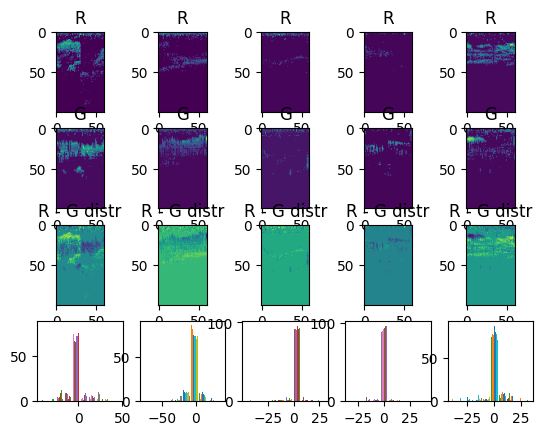

In [ ]:
plot_output(radar_gan, train_dataset)

1/1 [==============================] - 0s 27ms/step


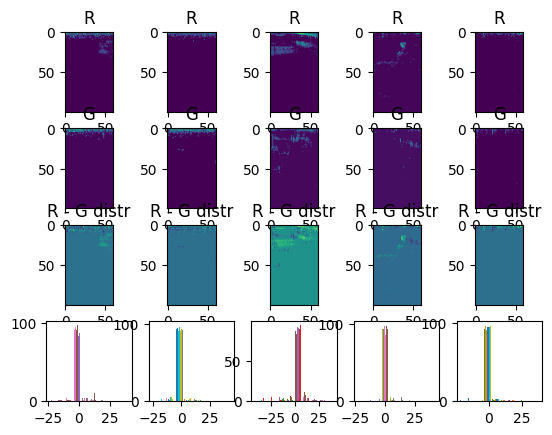

In [ ]:
plot_output(radar_gan, val_dataset)

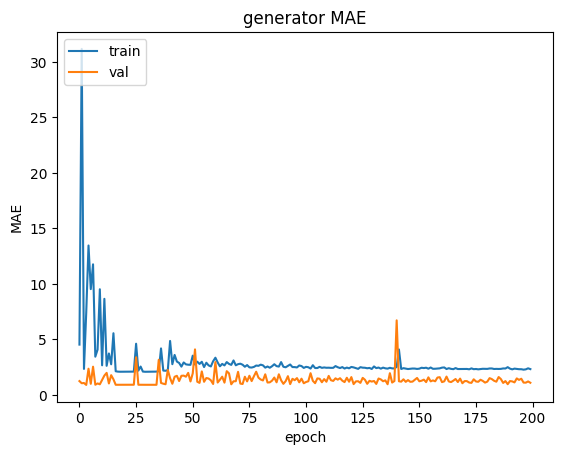

In [ ]:
plt.plot(hist.history['g_mae'])
plt.plot(hist.history['val_g_mae'])
plt.title('generator MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

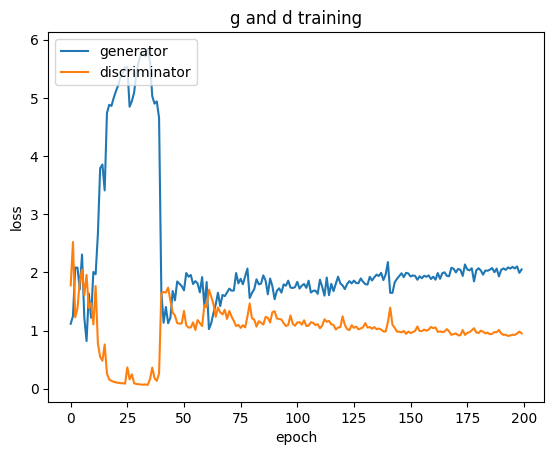

In [ ]:
plt.plot(hist.history['g_loss'])
plt.plot(hist.history['d_loss'])
plt.title('g and d training')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper left')
plt.show()

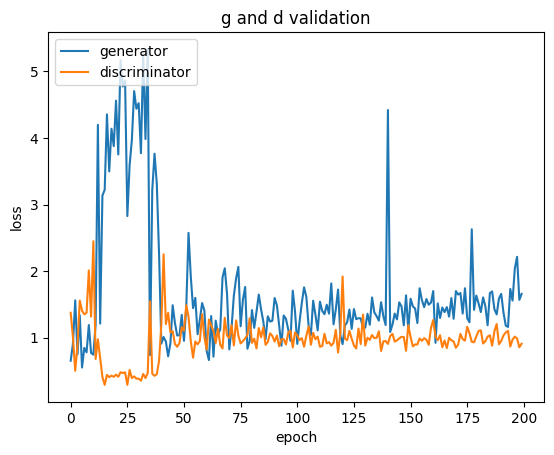

In [ ]:
plt.plot(hist.history['val_g_loss'])
plt.plot(hist.history['val_d_loss'])
plt.title('g and d validation')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['generator', 'discriminator'], loc='upper left')
plt.show()

In [ ]:
!zip models.zip drive/MyDrive/saved_*

  adding: drive/MyDrive/saved_discriminator_0_1.3748.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_discriminator_100_1.0364.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_discriminator_101_0.9640.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_discriminator_102_0.9941.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_discriminator_10_2.4495.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_discriminator_103_0.8650.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_discriminator_104_1.0289.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_discriminator_105_1.1695.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_discriminator_106_0.8943.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_discriminator_107_1.0735.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_discriminator_108_0.9775.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_discriminator_109_1.0170.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_discriminator_1_1.0013.hdf5 (deflated 15%)
  adding: drive/MyDrive/saved_

In [ ]:
!mv models.zip drive/MyDrive/